# 3D Protein Pose Recovery - Robustness to Unseen Protein

Through the following model, we consider that a cryo-EM measurement (i.e. 2D projection) $\mathbf{y}_i \in \mathbb{R}^{M}$ is acquired through
\begin{equation}
\label{eq:linear-forward-model}
\mathbf{y}_i={\mathbf {C}_{\boldsymbol\varphi}}\mathbf S_{\mathbf{t}}\mathbf P_{\theta_i}\mathbf x+\mathbf n,
\end{equation}
where $\mathbf x \in \mathbb{R}^{V}$ is the unknown 3D density map [*DiMaio et al.*](https://academic.oup.com/bioinformatics/article/23/21/2851/374177) (Coulomb potential). The operator $\mathbf P_{\theta_i}: \mathbb R^V \to \mathbb R^M$ is the projection along the 3D pose $\theta_i$ (i.e., the x-ray transform). The operator $\mathbf S_\mathbf{t}: \mathbb R^M \to \mathbb R^M$ is a shift of the projection by $\mathbf{t}=(t_1, t_2)$. The convolution operator $\mathbf {C}_{\boldsymbol\varphi}: \mathbb R^M \to \mathbb R^M$ models the microscope contrast transfer function (CTF) with parameters $\boldsymbol\varphi=(d_1, d_2, \alpha_{\rm ast})$, that are, respectively, the defocus-major, the defocus-minor and the angle of astigmatism. Finally, $\mathbf n \in \mathbb{R}^{M}$ represents an additive noise. Our goal is then to recover the angles $\theta_i$ from every projection $\mathbf y_i$. 

Final **goal**: We have $N$ protein 3D volumes that are used to create the training set of 2D projections $\{\mathbf y_{N, i}^{train}\}$. Another, unseen protein 3D volume $\mathbf x^{test}$ is used to create the test set of 2D projections $\{\mathbf y_i^{test}\}$. The set of projections is created using the projection $\mathbf P_{\theta_i}$ along the 3D pose $\theta_i$ as well as all the other operators (noise $\mathbf n$, CTF $\mathbf C_\varphi$, shift $\mathbf S_{\mathbf t}$) specified in the equation above. 


  $\{\mathbf x_1^{train}, ..., \mathbf x_N^{train}\}  \rightarrow \{\mathbf y_{N, i}^{train}\} = \{{\mathbf {C}_{\boldsymbol\varphi}}\mathbf S_{\mathbf{t}}\mathbf P_{\theta_i}\mathbf x_N^{train}+\mathbf n\}$
  

  $\mathbf x^{test} \rightarrow \{\mathbf y_i^{test}\} =\{{\mathbf {C}_{\boldsymbol\varphi}}\mathbf S_{\mathbf{t}}\mathbf P_{\theta_i}\mathbf x^{test}+\mathbf n\}$

In [2]:
import sys
sys.path.append("..") 
from cryoem.projections import generate_2D_projections
from cryoem.plots import plot_projection, plot_detector_pixels, plot_angles_count
from cryoem.preprocessing import preprocessing, train_val_test_split
from cryoem.distance_estimation import train_distance_estimation
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl
from cryoem.conversions import quaternion2euler
import matplotlib.pyplot as plt
from cryoem.conversions import d_q, euler2quaternion
from cryoem.reconstruction import reconstruct
from cryoem.plots import plot_dP_dQ
import h5py
import ipyvolume as ipv
import numpy as np
import tensorflow as tf
from tensorflow.python.client import device_lib 
tf.__version__

In [2]:
!echo $CUDA_VISIBLE_DEVICES

2


In [3]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17474082267314463202
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4928684322806011624
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 18418965817690991350
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11329617920
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 1496498217847255196
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:da:00.0, compute capability: 3.5"
]


## (1) Generate Sythetic Data

In [4]:
MRC_DIR         = "/mnt/scratch/students/MRC"
RESULTS_DIR     = "/mnt/scratch/students"

In [5]:
NUM_TRAIN_PROTEINS = 5
NUM_TEST_PROTEINS  = 2

In [6]:
PROTEINS  = ['6ejf', '1eg0', '5a1a', '5j0n', '1d3e', '1d3i', '1dgi', #'1dyl',
             '6bf8', '6wut', '6osj', '6asx', '6vkt', '6h25', '6rr7', '6y9x',
             '6iy7', '4v3a', '6t1y', '6g8z', '6vm2', '3j1u', '5owx', '3jb7',
             '6zhd', '6qm5', '6dso', '6c21', '1gw7', '6vam', '6snb', '6muw',
             '6mk1', '6caa', '2r1g', '6usf', '7bte', '6qvu', '2j37', '3j0i',
             '3iyk', '6cet', '7btr', '5fwp', '3j6g', '6qwl', '5a9k', '6ofj',
             '6th3', '6u1s', '6iok', '6fhl', '6up6', '2om7', '3jam', '1eg0', 
             '1gr5', '1gru', '1gw7', '1gw8', '1hb5']
PROTEINS_TRAIN = PROTEINS[:NUM_TRAIN_PROTEINS]
PROTEINS_TEST  = PROTEINS[NUM_TRAIN_PROTEINS:NUM_TRAIN_PROTEINS+NUM_TEST_PROTEINS]

In [7]:
# 2.0, 1.0, 0.5 - 1/4
# 2.0, 1.0, 2.0 - 1
# 2.0, 1.0, 1.0 - 1/2

In [8]:
PROJECTIONS_NUM_SINGLE = 1000
ANGLE_COVERAGE         = [2.0, 0.4, 2.0]
ANGLE_SHIFT            = [0., 0., 0.]

In [9]:
# generate sythetic data - 2D projections and their corresponding orientations from a given 3D protein
for protein in PROTEINS:
    generate_2D_projections(input_file_path=f"{MRC_DIR}/{protein}.mrc", 
                            ProjNber=PROJECTIONS_NUM_SINGLE,
                            AngCoverage=ANGLE_COVERAGE,
                            AngShift=ANGLE_SHIFT,
                            angles_gen_mode="uniform_angles",
                            output_file_name=f"{RESULTS_DIR}/{protein}_ProjectionsAngles_ProjNber{PROJECTIONS_NUM_SINGLE}_AngCoverage{','.join(map(str, ANGLE_COVERAGE))}_AngShift{','.join(map(str, ANGLE_COVERAGE))}.h5")

* Generating the dataset *

Projections: (1000, 443, 443)
Angles: (1000, 3)

* Generating the dataset *

Projections: (1000, 710, 710)
Angles: (1000, 3)

* Generating the dataset *

Projections: (1000, 275, 275)
Angles: (1000, 3)

* Generating the dataset *

Projections: (1000, 116, 116)
Angles: (1000, 3)

* Generating the dataset *

Projections: (1000, 427, 427)
Angles: (1000, 3)

* Generating the dataset *

Projections: (1000, 370, 370)
Angles: (1000, 3)

* Generating the dataset *

Projections: (1000, 507, 507)
Angles: (1000, 3)

* Generating the dataset *

Projections: (1000, 521, 521)
Angles: (1000, 3)

* Generating the dataset *

Projections: (1000, 387, 387)
Angles: (1000, 3)

* Generating the dataset *

Projections: (1000, 270, 270)
Angles: (1000, 3)

* Generating the dataset *

Projections: (1000, 476, 476)
Angles: (1000, 3)

* Generating the dataset *

Projections: (1000, 469, 469)
Angles: (1000, 3)

* Generating the dataset *

Projections: (1000, 471, 471)
Angles: (1000, 3)


In [9]:
# read stored data for further processing
projections_train = []
projections_original_train = []
angles_true_train = []
print(f"* Reading train dataset *")
for protein in PROTEINS_TRAIN:
    data = h5py.File(f"{RESULTS_DIR}/{protein}_ProjectionsAngles_ProjNber{PROJECTIONS_NUM_SINGLE}_AngCoverage{','.join(map(str, ANGLE_COVERAGE))}_AngShift{','.join(map(str, ANGLE_COVERAGE))}.h5", 'r')
    projections = data['Projections']
    angles_true = np.array(data['Angles'])
    projections_train.extend(projections)
    projections_original_train.extend(projections)
    angles_true_train.extend(angles_true)
    print(f"--- protein: {protein} ---")
    print(f"{projections.shape[0]} projections of images with dimension {projections.shape[1:]} pixels")
    print(f"{angles_true.shape[0]} sets of {angles_true.shape[1]} ground truth rotation angles (Z-Y-Z axes) of corresponding projection images")

projections_test = []
projections_original_test = []
angles_true_test = []
print(f"\n* Reading test dataset *")
for protein in PROTEINS_TEST:
    data = h5py.File(f"{RESULTS_DIR}/{protein}_ProjectionsAngles_ProjNber{PROJECTIONS_NUM_SINGLE}_AngCoverage{','.join(map(str, ANGLE_COVERAGE))}_AngShift{','.join(map(str, ANGLE_COVERAGE))}.h5", 'r')
    projections = data['Projections']
    angles_true = np.array(data['Angles'])
    projections_test.extend(projections)
    projections_original_test.extend(projections)
    angles_true_test.extend(angles_true)
    print(f"--- protein: {protein} ---")
    print(f"{projections.shape[0]} projections of images with dimension {projections.shape[1:]} pixels")
    print(f"{angles_true.shape[0]} sets of {angles_true.shape[1]} ground truth rotation angles (Z-Y-Z axes) of corresponding projection images")

* Reading train dataset *
--- protein: 6ejf ---
1000 projections of images with dimension (443, 443) pixels
1000 sets of 3 ground truth rotation angles (Z-Y-Z axes) of corresponding projection images
--- protein: 1eg0 ---
1000 projections of images with dimension (710, 710) pixels
1000 sets of 3 ground truth rotation angles (Z-Y-Z axes) of corresponding projection images
--- protein: 5a1a ---
1000 projections of images with dimension (275, 275) pixels
1000 sets of 3 ground truth rotation angles (Z-Y-Z axes) of corresponding projection images
--- protein: 5j0n ---
1000 projections of images with dimension (116, 116) pixels
1000 sets of 3 ground truth rotation angles (Z-Y-Z axes) of corresponding projection images
--- protein: 1d3e ---
1000 projections of images with dimension (427, 427) pixels
1000 sets of 3 ground truth rotation angles (Z-Y-Z axes) of corresponding projection images

* Reading test dataset *
--- protein: 1d3i ---
1000 projections of images with dimension (370, 370) pix

In [10]:
projections_train = np.array(projections_train)
projections_original_train = np.array(projections_original_train)
angles_true_train = np.array(angles_true_train)

projections_test = np.array(projections_test)
projections_original_test = np.array(projections_original_test)
angles_true_test = np.array(angles_true_test)

## (2) Preprocessing Data

In [11]:
NOISE_VAR_SCALE = 1   # it takes max px value to be the variance, since all proteins have it different
TRANSLATION = 5

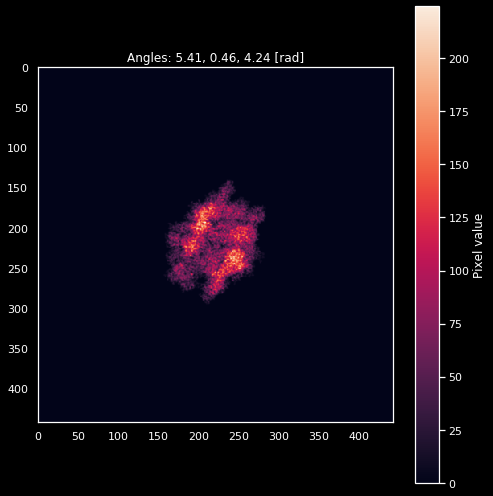

In [12]:
plot_projection(projections_train[0], angles=angles_true_train[0])

In [13]:
projections_train = preprocessing(projections_train, PROJECTIONS_NUM_SINGLE, rescale_dim=128, noise_var_scale=NOISE_VAR_SCALE, left_limit=-TRANSLATION, peak_limit=0, right_limit=TRANSLATION, channels=1)

--- Preprocessing projections ---
Protein # 1
Image rescaled: from dimension 443 to 128
Global standardization
	Image shape: (128, 128)
	Data Type: float64
	Mean: 4.126 | Std: 18.093
	Min:  0.000 | Max: 213.234
	Mean: -0.000 | Std: 1.000
	Min:  -0.228 | Max: 11.557
Noise:
Variance= 11.557191848754883
Translation:
left_limit=-5, peak_limit=0, right_limit=5
Protein # 2
Image rescaled: from dimension 710 to 128
Global standardization
	Image shape: (128, 128)
	Data Type: float64
	Mean: 0.091 | Std: 0.645
	Min:  0.000 | Max: 20.254
	Mean: -0.000 | Std: 1.000
	Min:  -0.141 | Max: 31.237
Noise:
Variance= 31.236827850341797
Translation:
left_limit=-5, peak_limit=0, right_limit=5
Protein # 3
Image rescaled: from dimension 275 to 128
Global standardization
	Image shape: (128, 128)
	Data Type: float64
	Mean: 2.955 | Std: 7.022
	Min:  0.000 | Max: 60.068
	Mean: 0.000 | Std: 1.000
	Min:  -0.421 | Max: 8.133
Noise:
Variance= 8.133097648620605
Translation:
left_limit=-5, peak_limit=0, right_limit=5
P

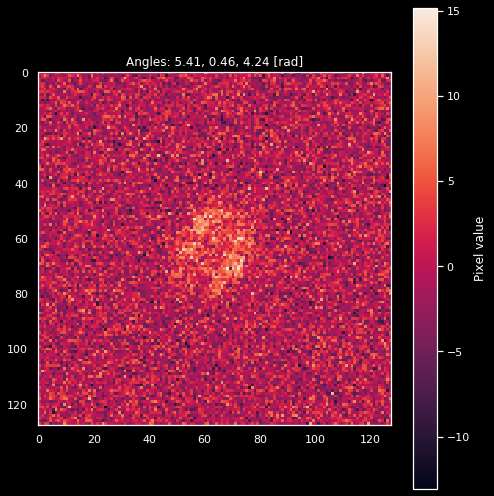

In [14]:
plot_projection(projections_train[0], angles=angles_true_train[0])

In [15]:
# do the same to test set projections
projections_test = preprocessing(projections_test, PROJECTIONS_NUM_SINGLE, rescale_dim=128, noise_var_scale=NOISE_VAR_SCALE, left_limit=-TRANSLATION, peak_limit=0, right_limit=TRANSLATION, channels=1)

--- Preprocessing projections ---
Protein # 1
Image rescaled: from dimension 370 to 128
Global standardization
	Image shape: (128, 128)
	Data Type: float64
	Mean: 0.008 | Std: 0.125
	Min:  0.000 | Max: 10.543
	Mean: -0.000 | Std: 1.000
	Min:  -0.060 | Max: 84.616
Noise:
Variance= 84.61564636230469
Translation:
left_limit=-5, peak_limit=0, right_limit=5
Protein # 2
Image rescaled: from dimension 507 to 128
Global standardization
	Image shape: (128, 128)
	Data Type: float64
	Mean: 0.101 | Std: 0.751
	Min:  0.000 | Max: 28.788
	Mean: 0.000 | Std: 1.000
	Min:  -0.135 | Max: 38.182
Noise:
Variance= 38.1823844909668
Translation:
left_limit=-5, peak_limit=0, right_limit=5


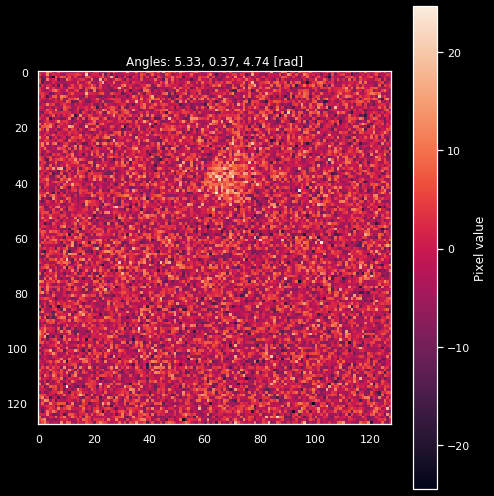

In [16]:
plot_projection(projections_test[1000], angles=angles_true_test[1000])

In [18]:
from cryoem.plots import plot_detector_pixels

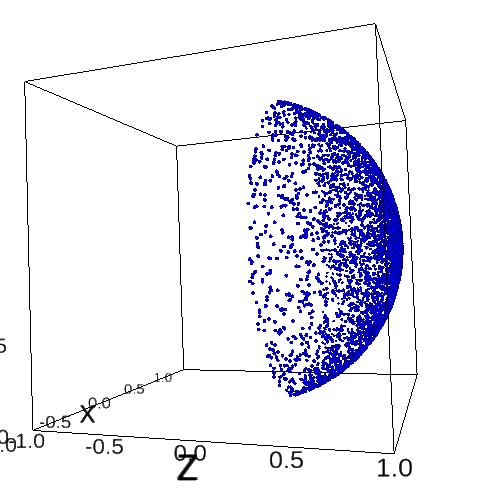

In [19]:
plot_detector_pixels(angles_true_train)

In [20]:
ipv.screenshot()

Output()

## (3) Distance Learning

In [17]:
PROJECTIONS_NUM = NUM_TRAIN_PROTEINS * PROJECTIONS_NUM_SINGLE
PROJECTIONS_NUM

5000

In [18]:
DE_LOGS_DIR = f"{RESULTS_DIR}/distance_estimation"
DE_DESCRIPTION = "full_pipeline_unseen_proteins"

In [19]:
train_idx, val_idx, test_idx, train_pairs_num, val_pairs_num = train_val_test_split(PROJECTIONS_NUM, test_size=0.0001, val_size=0.35, train_percent=0.01, val_percent=0.01, indices_file="")

TRAIN: 1.00 x 0.65 = 0.65 =>  3249 imgs => max pairs:   10556001   |   105560
TEST :             0.0001 =>     1 imgs => max pairs:          1   |   all
VAL  : 1.00 x 0.35 = 0.35 =>  1750 imgs => max pairs:    3062500   |   30625
Indices stored in 


In [ ]:
model, history = train_distance_estimation(X=projections_train, y=angles_true_train, 
                                           train_idx=train_idx, 
                                           val_idx=val_idx,
                                           epochs=100,
                                           batch_size=256,  #512 latest 
                                           learning_rate=1e-3, 
                                           limit_style="random", 
                                           path_logs_training=DE_LOGS_DIR, 
                                           training_description=DE_DESCRIPTION,
                                           training_steps=train_pairs_num,
                                           validation_steps=val_pairs_num, 
                                           plot=True,
                                           gpus=None)

Data created in 8.216578722000122 sec
Data created in 2.145289182662964 sec
Input images shape (128, 128, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________

413/413 [==============================] - 446s 1s/step - loss: 0.1341 - mse: 0.0319 - val_loss: 0.6713 - val_mse: 0.7462
Epoch 40/100
413/413 [==============================] - 447s 1s/step - loss: 0.1340 - mse: 0.0318 - val_loss: 0.6795 - val_mse: 0.7619
Epoch 41/100
413/413 [==============================] - 445s 1s/step - loss: 0.1337 - mse: 0.0318 - val_loss: 0.6728 - val_mse: 0.7486
Epoch 42/100
413/413 [==============================] - 445s 1s/step - loss: 0.1331 - mse: 0.0316 - val_loss: 0.6776 - val_mse: 0.7576
Epoch 43/100
413/413 [==============================] - 449s 1s/step - loss: 0.1329 - mse: 0.0316 - val_loss: 0.6787 - val_mse: 0.7598
Epoch 44/100
413/413 [==============================] - 448s 1s/step - loss: 0.1326 - mse: 0.0315 - val_loss: 0.6723 - val_mse: 0.7492
Epoch 45/100
413/413 [==============================] - 451s 1s/step - loss: 0.1326 - mse: 0.0315 - val_loss: 0.6766 - val_mse: 0.7576
Epoch 46/100
413/413 [==============================] - 449s 1s/step

In [20]:
# read stored model
model_filename = f"{DE_LOGS_DIR}/training/{DE_DESCRIPTION}.h5"

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [21]:
# learned distance function
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=512)

<Figure size 432x288 with 0 Axes>

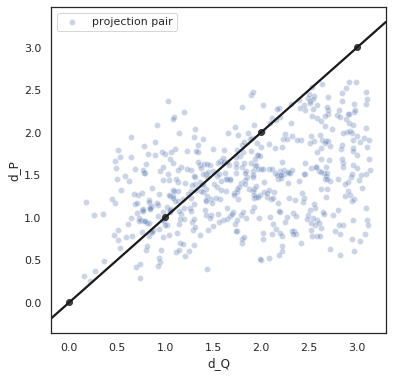

<Figure size 432x288 with 0 Axes>

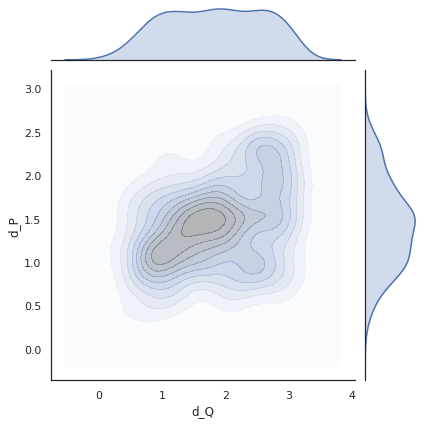

Variance = 0.8431434333621441
Min. angle recovery loss possible = 0.7095023905318182


In [22]:
# dP/dQ ratio plot
batch_size = 512
idx1 = list(np.random.choice(range(5000), size=batch_size))
idx2 = list(np.random.choice(range(5000), size=batch_size))

q1_true = euler2quaternion([angles_true_train[i] for i in idx1])
q2_true = euler2quaternion([angles_true_train[i] for i in idx2])

p1 = [projections_train[i] for i in idx1]
p2 = [projections_train[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

plot_dP_dQ(dP_values, dQ_values, f"{DE_LOGS_DIR}/dPdQ.png");

## (4) Angle Recovery

In [23]:
from cryoem.angle_recovery import train_angle_recovery

In [5]:
AR_LOGS_DIR = f"{RESULTS_DIR}/angle_recovery"
AR_TRAINING_DESCRIPTION = "full_pipeline_unseen_proteins"

In [25]:
projections_test.shape

(2000, 128, 128, 1)

In [26]:
# # QUATERNION VARIABLE
# import time
# import numpy as np
# from IPython import display as IPyDisplay
# from tensorflow.keras.optimizers import Adam
# import seaborn as sns; sns.set(style="white", color_codes=True)
# from tensorflow_graphics.geometry.transformation import quaternion
# from cryoem.conversions import euler2quaternion, d_q, quaternion2euler
# import tensorflow as tf
# import matplotlib.pyplot as plt
# from scipy.spatial.transform import Rotation as R
# from pathlib import Path

# # TODO: add constraint on quaternion Variables


# def angles_transpose(angles):
#     angles = angles.copy()
#     cols = [2, 1, 0]
#     idx = np.empty_like(cols)
#     idx[cols] = np.arange(len(cols))
#     angles[:] = -angles[:, idx]
#     return angles

# def quaternion_constraint(low_ang, high_ang):
    
#     def _inner(q):
#         e = quaternion2euler(q)

#         a0, a1, a2 = tf.unstack(e, axis=-1)
#         a0 = tf.math.mod(a0, 2*np.pi)
#         a1 = tf.math.mod(a1, np.pi)
#         a2 = tf.math.mod(a2, 2*np.pi)
#         a0 = tf.clip_by_value(a0, low_ang[0], high_ang[0])
#         a1 = tf.clip_by_value(a1, low_ang[1], high_ang[1])
#         a2 = tf.clip_by_value(a2, low_ang[2], high_ang[2])

#         e_new = tf.stack((a0, a1, a2), axis=-1)
#         q_new = euler2quaternion(e_new)
#         return q_new

#     return _inner
    


# def train_angle_recovery(steps, 
#                          batch_size, 
#                          in_data, 
#                          distance_fn, 
#                          file_name,
#                          limit_distance=np.pi,
#                          low_ang_const=[0.0, 0.0, 0.0],
#                          high_ang_const=[2.0, 0.4, 2.0],
#                          q_predicted=None,
#                          angles_true=None,
#                          learning_rate=0.01,
#                         constraint=False): 

#     time_start = time.time()
#     collect_data = []
#     optimizer = Adam(learning_rate=learning_rate)

#     #low_ang = [0.0*np.pi, 0.0*np.pi, 0.0*np.pi]
#     low_ang = list(map(lambda x: x*np.pi, low_ang_const))
#     #high_ang = [2.0*np.pi, 0.4*np.pi, 2.0*np.pi] 
#     high_ang = list(map(lambda x: x*np.pi, high_ang_const))           
#     euler = np.random.uniform(low=[low_ang[0], low_ang[1], low_ang[2]], 
#                           high=[high_ang[0], high_ang[1], high_ang[2]],
#                           size=(len(in_data), 3))
#     if q_predicted:
#         # continue where left off
#         if constraint:
#             q_predicted = [tf.Variable(q, constraint=quaternion_constraint(low_ang, high_ang)) for q in q_predicted]
#         else:
#             q_predicted = [tf.Variable(q) for q in q_predicted]
#     else:
#         # optimize from scratch
#         if constraint:
#             q_predicted = [tf.Variable(q, constraint=quaternion_constraint(low_ang, high_ang)) for q in euler2quaternion(euler)]
#         else:
#             q_predicted = [tf.Variable(q) for q in euler2quaternion(euler)]

#     if in_data.shape[1] == 3:
#         in_data = euler2quaternion(in_data)

#     losses = np.empty(steps)
#     report = f"Shape of projections: {in_data.shape}"
#     found_minimizer = False

#     print(time.time()-time_start)

#     for step, idx1, idx2 in sample_iter(steps, range(len(in_data)), batch_size, style="random"):
#         q1 = [q_predicted[i] for i in idx1]
#         q2 = [q_predicted[i] for i in idx2]
#         q1 = np.array(q1)
#         q2 = np.array(q2)

#         # Compute distances
#         in1 = [in_data[i] for i in idx1]
#         in2 = [in_data[i] for i in idx2]
#         in1 = np.array(in1)
#         in2 = np.array(in2)

#         distance_target = distance_fn(in1, in2)

#         # WORK ONLY WITH LIMITED DISTANCES 
#         indices_le2 = np.where(distance_target<limit_distance)[0]
#         distance_target = np.take(distance_target, indices_le2)
#         q1 = list(np.take(q1, indices_le2))
#         q2 = list(np.take(q2, indices_le2))
#         in1 = list(np.take(in1, indices_le2))
#         in2 = list(np.take(in2, indices_le2))

#         # Optimize by gradient descent.
#         losses[step-1], gradients = gradient(q1, q2, distance_target)
#         optimizer.apply_gradients(zip(gradients, q1 + q2))

#         # Visualize progress periodically
#         if step % 10 == 0:
#             a = np.zeros((len(q_predicted), 4))
#             for i, e in enumerate(q_predicted):
#                 a[i] = e.numpy()
#             collect_data.append(a)

#             plt.close();
#             sns.set(style="white", color_codes=True)
#             sns.set(style="whitegrid")

#             if angles_true is not None:
#                 fig, axs = plt.subplots(1, 3, figsize=(24,7))

#                 # Optimization loss subplot
#                 axs[0].plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
#                 axs[0].set_xlabel('time [s]')
#                 axs[0].set_ylabel('loss');
#                 axs[0].set_title(f"[{step}/{steps}] Angle alignment optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")

#                 # NT - Distance count subplot (full)
#                 d2 = d_q(R.from_euler('zyz', angles_true).as_quat(), q_predicted)
#                 axs[1].set_xlim(0, np.pi)
#                 axs[1].set_title(f"[{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
#                 s = sns.distplot(d2, kde=False, bins=100, ax=axs[1], axlabel="Distance [rad]", color="r")
#                 max_count = int(max([h.get_height() for h in s.patches]))
#                 axs[1].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

#                 # T - Distance count subplot (full)
#                 angles_true_T = angles_transpose(angles_true)
#                 d2 = d_q(R.from_euler('zyz', angles_true_T).as_quat(), q_predicted)
#                 axs[2].set_xlim(0, np.pi)
#                 axs[2].set_title(f"[{step}/{steps}] TRANSPOSED Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
#                 s = sns.distplot(d2, kde=False, bins=100, ax=axs[2], axlabel="Distance [rad]", color="r")
#                 max_count = int(max([h.get_height() for h in s.patches]))
#                 axs[2].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
#             else:
#                 fig, axs = plt.subplots(figsize=(10,7))

#                 # Optimization loss subplot
#                 axs.plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
#                 axs.set_xlabel('time [s]')
#                 axs.set_ylabel('loss');
#                 axs.set_title(f"[{step}/{steps}] Angle recovery optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")


#             IPyDisplay.clear_output(wait=True)
#             IPyDisplay.display(plt.gcf())
#             plt.close();
#             time.sleep(0.1)

#             Path(file_name).mkdir(parents=True, exist_ok=True)
#             np.savez(file_name, quaternion.normalize(q_predicted).numpy(), losses, np.array(collect_data))

#             if found_minimizer:
#                 time_elapsed = time.time() - time_start
#                 report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}\n'
#                 break;

#         # Periodically report progress.
#         if ((step % (steps//10)) == 0) or (step == steps):
#             time_elapsed = time.time() - time_start
#             report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}\n'

#         if step >= 1001 and np.mean(losses[step-1001:step-1]) < 1e-8:
#             found_minimizer = True

#         if step >= 2001 and np.abs(np.mean(losses[step-1000:step-1])-np.mean(losses[step-2000:step-1000])) < 1e-7:
#             found_minimizer = True

#     print(report)
#     return quaternion.normalize(q_predicted).numpy(), losses, np.array(collect_data)

# def sample_iter(steps, projection_idx, num_pairs, style="random", k=None):

#     for step in range(1, steps+1):
#         if not k and style != "random":
#             raise ValueError("Please specify k for kNN for sample_pairs method")

#         if style=="random":
#             idx1 = list(np.random.choice(projection_idx, size=num_pairs))
#             idx2 = list(np.random.choice(projection_idx, size=num_pairs))

#         elif style=="knn":
#             idx1 = list(np.random.choice(projection_idx, size=num_pairs))
#             indices_p, distances_p, A_p = get_knn_projections(k=k)
#             idx2 = [indices_p[i][np.random.randint(1, k)] for i in idx1]

#         elif style=="knn_and_random":
#             # select random sample for the first element of pair
#             idx1 = list(np.random.choice(projection_idx, size=num_pairs))

#             # half from kNN
#             indices_p, distances_p, A_p = get_knn_projections(k=k)
#             idx2_knn = [indices_p[i][np.random.randint(1, k)] for i in idx1[:num_pairs//2]]
#             idx2_random = list(np.random.randint(0, num_projections, num_pairs//2))
#             # half random
#             idx2 = idx2_knn + idx2_random

#         yield step, idx1, idx2

# def loss(q1_predicted, q2_predicted, distance_target):
#     # The mean doesn't depend on the batch size.
#     return tf.reduce_mean(tf.pow((d_q(q1_predicted, q2_predicted) - distance_target), 2))

# def gradient(q1_predicted, q2_predicted, distance_target):
#     with tf.GradientTape() as tape:
#         loss_value = loss(q1_predicted, q2_predicted, distance_target)
#     gradient = tape.gradient(loss_value, q1_predicted + q2_predicted)

#     return loss_value, gradient



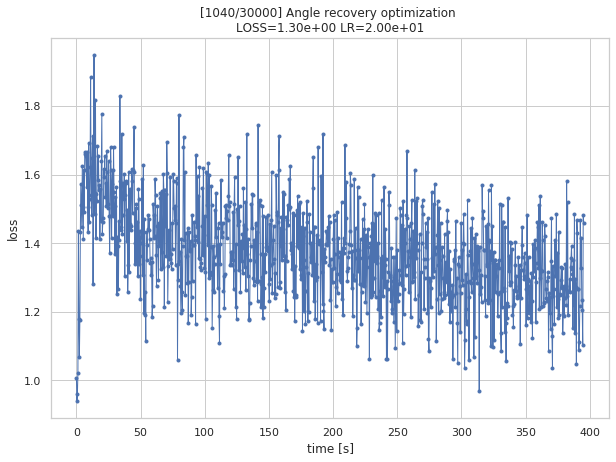

In [ ]:
q_predicted, losses, q_all = train_angle_recovery(steps=30000, 
                                                 batch_size=128, 
                                                 in_data=projections_test, 
                                                 distance_fn=d_p, 
                                                 learning_rate=20, 
                                                 limit_distance=np.pi,
                                                 low_ang_const=ANGLE_SHIFT,
                                                 high_ang_const=[sum(x) for x in zip(ANGLE_SHIFT, ANGLE_COVERAGE)],
                                                 file_name=f"{AR_LOGS_DIR}/{AR_TRAINING_DESCRIPTION}",
                                                 constraint=False)

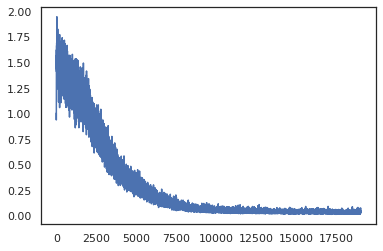

In [11]:
data = np.load(f"{AR_LOGS_DIR}/{AR_TRAINING_DESCRIPTION}.npz")
q_predicted, losses, collect_data = data['arr_0'], data['arr_1'], data['arr_2']
plt.plot(data["arr_1"][:19000])

In [29]:
angles_predicted = quaternion2euler(q_predicted)

## (5) Angle Alignment

m= [1.0, 1.0, 1.0, -1.0] 
trajectory_first= [2.21381307 4.21082727 6.05729721 2.50499441 3.13559196 4.98822685] 
loss_first= 2.560397231414104 
trajectory_last= [11.4809362  10.47275374 -0.61039732 -9.98583116 18.08263311  1.18038556] 
loss_last= 1.5161086903482268


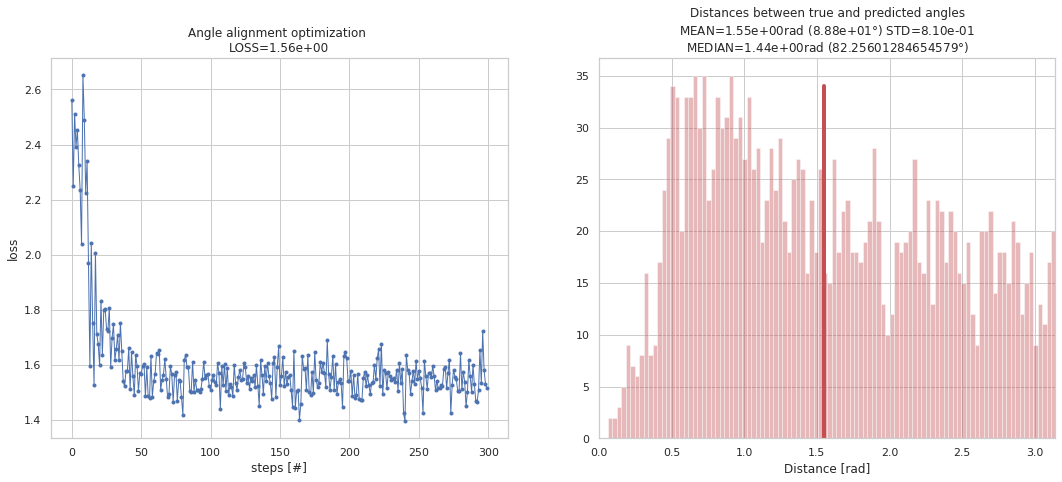

In [30]:
%matplotlib inline
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                                    steps=300, 
                                                                    batch_size=256, 
                                                                    optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                                    angles_true=angles_true_test, 
                                                                    angles_predicted=angles_predicted,
                                                                    threshold=None)

In [32]:
from cryoem.plots import plot_rays, plot_iterations_rotvec, plot_rotvec

In [101]:
rv1 = R.from_rotvec([[0, 0, -np.pi], [np.pi/2, 0, np.pi/2]])
e1 = rv1.as_euler('zyz')
print(e1)

#rv1_new = np.empty(rv1.shape)
#r = 2.0
#rv1_new[:,0] = -rv1[:,0]
#rv1_new[:,1] = -r*(np.sin(rv1[:,2]))+(np.sin(rv1[:,1]))
#rv1_new[:,2] = -r*(np.cos(rv1[:,2]))+(np.cos(rv1[:,1]))

e1 = R.from_euler('zyz', e1).as_rotvec()
print(e1)

[[-3.14159265  0.          0.        ]
 [ 2.53032762  1.37234625 -0.61126504]]
[[ 0.00000000e+00  0.00000000e+00 -3.14159265e+00]
 [ 1.57079633e+00  6.88125933e-17  1.57079633e+00]]


In [97]:
e1 = R.from_euler('xyz', [[0, 0, -np.pi], [np.pi, np.pi, 0]])
rv1 = e1.as_rotvec()
print(rv1)

#rv1_new = np.empty(rv1.shape)
#r = 2.0
#rv1_new[:,0] = -rv1[:,0]
#rv1_new[:,1] = -r*(np.sin(rv1[:,2]))+(np.sin(rv1[:,1]))
#rv1_new[:,2] = -r*(np.cos(rv1[:,2]))+(np.cos(rv1[:,1]))

e1 = R.from_rotvec(rv1).as_euler('xyz')
print(e1)

[[ 0.00000000e+00  0.00000000e+00 -3.14159265e+00]
 [ 1.92367069e-16  1.92367069e-16 -3.14159265e+00]]
[[ 0.00000000e+00  0.00000000e+00 -3.14159265e+00]
 [-1.22464680e-16  2.22044605e-16 -3.14159265e+00]]


In [39]:
np.min(angles_true_test, axis=0)

array([0.00069033, 0.00070589, 0.00703152])

In [40]:
np.min(angles_predicted, axis=0)

array([-3.13754722,  0.05377679, -3.14017331])

In [41]:
np.max(angles_true_test, axis=0)

array([6.27926826, 1.25624894, 6.28225958])

In [42]:
np.max(angles_predicted, axis=0)

array([3.13960665, 2.8163157 , 3.14022599])

In [43]:
from scipy.spatial.transform import Rotation as R

In [58]:
e2 = R.from_euler('zyz', angles_true_test)
rv2 = e2.as_rotvec()

In [87]:
e1 = R.from_euler('zyz', angles_true_test)
rv1 = e1.as_rotvec()

rv1_new = np.empty(rv1.shape)
r = 2.0
rv1_new[:,0] = -rv1[:,0]
rv1_new[:,1] = -r*(np.sin(rv1[:,2]))+(np.sin(rv1[:,1]))
rv1_new[:,2] = -r*(np.cos(rv1[:,2]))+(np.cos(rv1[:,1]))

e1 = R.from_rotvec(rv1_new).as_euler('zyz')

In [88]:
plot_rotvec(e1)

In [89]:
plot_iterations_rotvec(collect_data, e1, interval=1000, connections=True, selected=None)

---

In [49]:
plot_rotvec(angles_predicted)

In [48]:
plot_rotvec(angles_true_test)

In [69]:
trajectory.shape

(301, 6)

In [21]:
q_predicted_rotated =  update_quaternion(m, a_R, q_predicted)
angles_predicted_rotated = quaternion2euler(q_predicted_rotated)

## (6) Reconstruction

In [22]:
REC_LOGS_DIR = f"{RESULTS_DIR}/reconstruction"
REC_DESCRIPTION = "full_pipeline_test.mrc"

In [65]:
angles_predicted

<tf.Tensor: id=2689, shape=(5000, 3), dtype=float64, numpy=
array([[-0.8220658 ,  2.17608077, -2.52536372],
       [ 0.10819772,  1.41221318, -1.9608031 ],
       [-1.53205775,  1.75013525, -1.42568537],
       ...,
       [ 2.86390027,  0.40231196, -2.48562884],
       [-0.52721484,  0.98831919, -0.25038959],
       [-0.54727579,  1.97187616, -2.04459372]])>

In [66]:
angles_predicted_rotated

<tf.Tensor: id=3715234, shape=(5000, 3), dtype=float64, numpy=
array([[-1.2095774 ,  1.93953642,  0.46417235],
       [-2.41637719,  1.65122049,  0.09435763],
       [-1.62854121,  0.41662784,  0.76488605],
       ...,
       [ 0.24401382,  0.0737032 ,  1.63295391],
       [ 2.96905607,  0.09507884,  0.67494988],
       [-1.56681506,  1.65131866,  0.25850483]])>

In [67]:
angles_true

array([[5.14627844, 1.85293424, 0.50856176],
       [3.98451262, 1.73211982, 0.29329689],
       [4.57612295, 0.46516583, 0.89836796],
       ...,
       [1.42731449, 0.01055685, 0.5367215 ],
       [2.62138403, 0.12821249, 1.09304194],
       [4.64677858, 1.66052989, 0.31725796]])

In [124]:
import numpy as np
from os import mkdir
from os.path import join, isdir
from imageio import imread, imwrite
from cryoem.rotation_matrices import RotationMatrix
import astra
import mrcfile
from pathlib import Path

def reconstruct(projections, angles, mrc_filename=None, overwrite=False):
    # Generate orientation vectors based on angles
    orientation_vectors   = RotationMatrix(angles)

    # Reshape projections correctly 
    projections1 = np.transpose(projections, (1, 0, 2))
    
    # Get projection dimension
    proj_size = projections1.shape[0]

    # Create projection 2D geometry in ASTRA
    proj_geom = astra.create_proj_geom('parallel3d_vec', proj_size, proj_size, orientation_vectors)
    #proj_geom = astra.create_proj_geom('parallel3d', 0.5, 0.5, proj_size, proj_size, orientation_vectors)
    projections_id = astra.data3d.create('-sino', proj_geom, projections1)

    # Create reconstruction.
    vol_geom = astra.creators.create_vol_geom(proj_size, proj_size, proj_size)
    reconstruction_id = astra.data3d.create('-vol', vol_geom, data=0)
    alg_cfg = astra.astra_dict('BP3D_CUDA')
    alg_cfg['ProjectionDataId'] = projections_id
    alg_cfg['ReconstructionDataId'] = reconstruction_id
    algorithm_id = astra.algorithm.create(alg_cfg)
    astra.algorithm.run(algorithm_id)
    reconstruction = astra.data3d.get(reconstruction_id)


    # Limit and scale reconstruction.
    reconstruction[reconstruction < 0] = 0
    reconstruction /= np.max(reconstruction)
    reconstruction = np.round(reconstruction * 255).astype(np.uint8)

    # Cleanup.
    astra.algorithm.delete(algorithm_id)
    astra.data3d.delete(reconstruction_id)
    astra.data3d.delete(projections_id)


    # Save reconstruction to mrc file for chimera
    if mrc_filename:
        Path(mrc_filename).parent.mkdir(parents=True, exist_ok=True)
        with mrcfile.new(mrc_filename, overwrite=overwrite) as mrc:
            mrc.set_data(reconstruction)
        
    return reconstruction

def reconstruct_from_file(input_file, limit=3000, mrc_filename=None):
    data = np.load(f'data/{input_file}.npz')
    projections, angles = data["arr_0"].astype(np.float64)[:limit, :, :], data["arr_1"].astype(np.float64)[:limit, :]

    return reconstruct(projections, angles, mrc_filename)


In [125]:
reconstruction_pred = reconstruct(projections_original, angles_predicted, mrc_filename=False, overwrite=False)
reconstruction_pred = reconstruction_pred.astype(np.float)

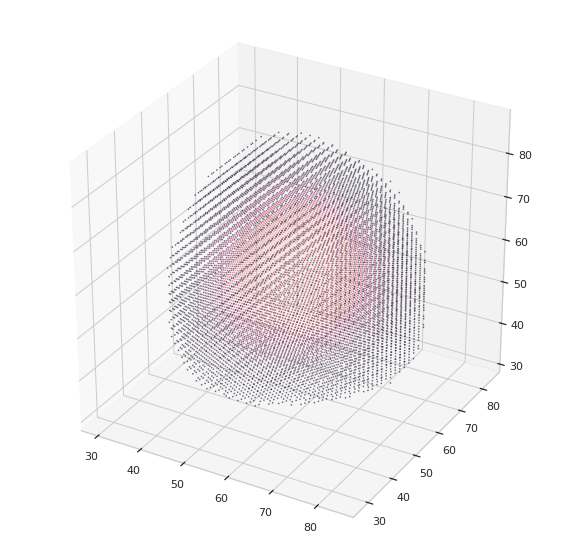

In [126]:
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
step = 2

volume = reconstruction_pred 
volume[volume<50.] = np.nan

x = np.arange(volume.shape[0])[::step, None, None]
y = np.arange(volume.shape[1])[None, ::step, None]
z = np.arange(volume.shape[2])[None, None, ::step]
x, y, z = np.broadcast_arrays(x, y, z)
c = volume[::step,::step,::step].ravel()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')
ax.scatter(x.ravel(),
           y.ravel(),
           z.ravel(), alpha=0.5, s=0.5,
           c=c)

In [57]:
reconstruction = reconstruct(projections_original, angles_predicted_rotated, mrc_filename=f"{REC_LOGS_DIR}/{REC_DESCRIPTION}", overwrite=True)
reconstruction = reconstruction.astype(np.float)

In [58]:
reconstruction_true = reconstruct(projections_original, angles_true, mrc_filename=False, overwrite=False)
reconstruction_true = reconstruction_true.astype(np.float)

/home/jbanjac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


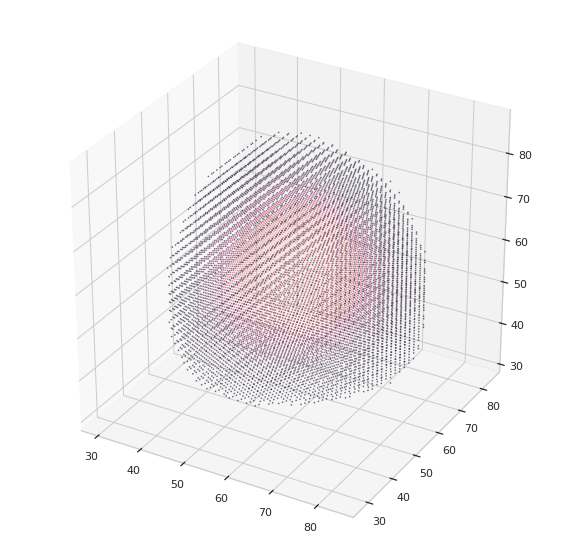

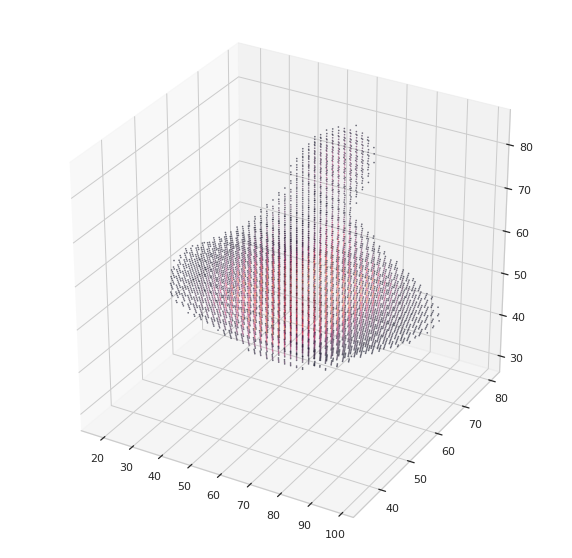

In [25]:
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
step = 2

volume = reconstruction 
volume[volume<50.] = np.nan

x = np.arange(volume.shape[0])[::step, None, None]
y = np.arange(volume.shape[1])[None, ::step, None]
z = np.arange(volume.shape[2])[None, None, ::step]
x, y, z = np.broadcast_arrays(x, y, z)
c = volume[::step,::step,::step].ravel()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')
ax.scatter(x.ravel(),
           y.ravel(),
           z.ravel(), alpha=0.5, s=0.5,
           c=c)

volume_true = reconstruction_true 
volume_true[volume_true<70.] = np.nan

x_t = np.arange(volume_true.shape[0])[::step, None, None]
y_t = np.arange(volume_true.shape[1])[None, ::step, None]
z_t = np.arange(volume_true.shape[2])[None, None, ::step]
x_t, y_t, z_t = np.broadcast_arrays(x_t, y_t, z_t)
c_t = volume_true[::step,::step,::step].ravel()

#fig = plt.figure(figsize = (10, 10))
#ax = fig.gca(projection='3d')
# ax.scatter(x_t.ravel(),
#            y_t.ravel(),
#            z_t.ravel(), alpha=0.5, s=0.5,
#            c=c_t)

/home/jbanjac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


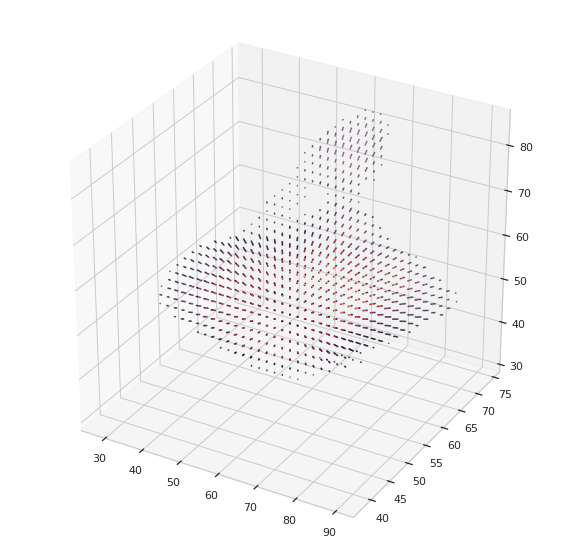

In [26]:
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
step = 2

volume_true = reconstruction_true 
volume_true[volume_true<50.] = np.nan

x_t = np.arange(volume_true.shape[0])[::step, None, None]
y_t = np.arange(volume_true.shape[1])[None, ::step, None]
z_t = np.arange(volume_true.shape[2])[None, None, ::step]
x_t, y_t, z_t = np.broadcast_arrays(x_t, y_t, z_t)
c_t = volume_true[::step,::step,::step].ravel()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')
ax.scatter(x_t.ravel(),
           y_t.ravel(),
           z_t.ravel(), alpha=0.5, s=0.5,
           c=c_t)

/home/jbanjac/miniconda3/envs/protein_reconstruction/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/jbanjac/miniconda3/envs/protein_reconstruction/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


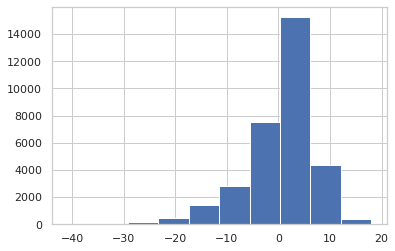

In [27]:
%matplotlib inline
plt.hist(reconstruction.ravel()-reconstruction_true.ravel());
plt.show()

In [28]:
reconstruction.ravel()[~np.isnan(reconstruction.ravel())]

array([50., 50., 50., ..., 50., 50., 50.])

In [29]:
reconstruction_true.ravel()[~np.isnan(reconstruction_true.ravel())]

array([70., 70., 72., ..., 71., 70., 70.])

In [30]:
volume_true.ravel()[~np.isnan(volume_true.ravel())]

array([70., 70., 72., ..., 71., 70., 70.])

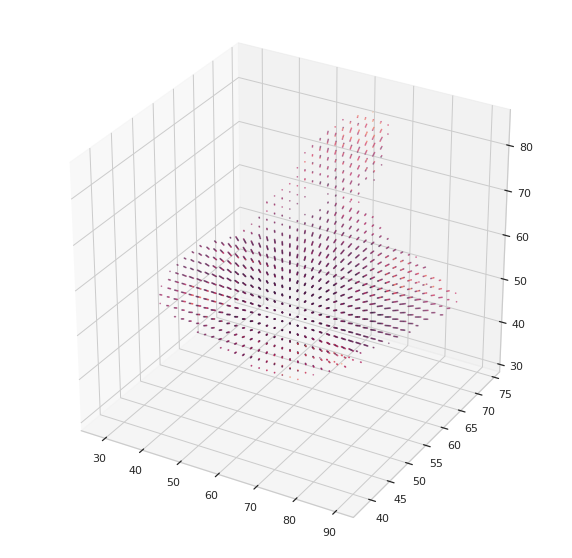

In [31]:
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
step = 2

volume_true = reconstruction_true - reconstruction
#volume_true[volume_true<50.] = np.nan

x_t = np.arange(volume_true.shape[0])[::step, None, None]
y_t = np.arange(volume_true.shape[1])[None, ::step, None]
z_t = np.arange(volume_true.shape[2])[None, None, ::step]
x_t, y_t, z_t = np.broadcast_arrays(x_t, y_t, z_t)
c_t = volume_true[::step,::step,::step].ravel()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')
ax.scatter(x_t.ravel(),
           y_t.ravel(),
           z_t.ravel(), alpha=0.5, s=0.5,
           c=c_t)

In [43]:
volume_true = reconstruction_true - reconstruction

In [59]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(reconstruction_true.ravel(), reconstruction.ravel())
#np.mean_square_error(volume_true.ravel()[~np.isnan(volume_true.ravel())])
mse

3.7193221073024723